## Load the data

We first load the fMRI responses. The data is separated into a training set ``Y_train`` and a
testing set ``Y_validation``. The training set is used for fitting models, and
selecting the best models and hyperparameters. The test set is later used
to estimate the generalization performance of the selected model



In [1]:
import os
import numpy as np
from src.utils.io import load_hdf5_array

file_name = './Data/RegressionDatasets/aligned_brain_data.h5'

Y_train = load_hdf5_array(file_name, key="Y_train")
Y_validation = load_hdf5_array(file_name, key="Y_validation")

print("(n_samples_train, n_voxels) =", Y_train.shape)
print("(n_samples_validation, n_voxels) =", Y_validation.shape)

(n_samples_train, n_voxels) = (1200, 79681)
(n_samples_validation, n_voxels) = (600, 79681)


We fill potential NaN (not-a-number) values with zeros.



In [2]:
Y_train = np.nan_to_num(Y_train)
Y_validation = np.nan_to_num(Y_validation)

Then, we load the IDM features, extracted from the stimulus at
each time point. The features corresponding to the training set are noted
``X_train``, and the features corresponding to the test set are noted
``X_validation``.

In [3]:
feature_name = "idm"

file_name = f"./Data/RegressionDatasets/{feature_name}_features.h5"
X_train = load_hdf5_array(file_name, key="X_train")
X_validation= load_hdf5_array(file_name, key="X_validation")

print("(n_samples_train, n_features) =", X_train.shape)
print("(n_samples_validation, n_features) =", X_validation.shape)

(n_samples_train, n_features) = (1200, 48)
(n_samples_validation, n_features) = (600, 48)


## Define the cross-validation scheme

To select the best hyperparameter through cross-validation, we must define a
cross-validation splitting scheme. Because fMRI time-series are
autocorrelated in time, we should preserve as much as possible the temporal
correlation. In other words, because consecutive time samples are correlated,
we should not put one time sample in the training set and the immediately
following time sample in the validation set. Thus, we define here a
leave-one-run-out cross-validation split that keeps each recording run
intact.



In [4]:
from sklearn.model_selection import check_cv
from src.utils.tutorial_utils import generate_leave_one_run_out

# indice of first sample of each run
offsets_file = "./Data/RegressionDatasets/train_run_offsets.h5"
demonstration_offsets = load_hdf5_array(offsets_file, key="run_offsets")
#print(demonstration_offsets)


We define a cross-validation splitter, compatible with ``scikit-learn`` API.



In [5]:
n_samples_train = X_train.shape[0]
cv = generate_leave_one_run_out(n_samples_train, demonstration_offsets)
cv = check_cv(cv)  # copy the cross-validation splitter into a reusable list

## Define the model

Now, let's define the model pipeline.

We first center the features, since we will not use an intercept. The mean
value in fMRI recording is non-informative, so each run is detrended and
demeaned independently, and we do not need to predict an intercept value in
the linear model.

However, we prefer to avoid normalizing by the standard deviation of each
feature. If the features are extracted in a consistent way from the stimulus,
their relative scale is meaningful. Normalizing them independently from each
other would remove this information. Moreover, the wordnet features are
one-hot-encoded, which means that each feature is either present (1) or not
present (0) in each sample. Normalizing one-hot-encoded features is not
recommended, since it would scale disproportionately the infrequent features.



In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=True, with_std=False)

Then we concatenate the features with multiple delays to account for the
hemodynamic response. Due to neurovascular coupling, the recorded BOLD signal
is delayed in time with respect to the stimulus onset. With different delayed
versions of the features, the linear regression model will weigh each delayed
feature with a different weight to maximize the predictions. With a sample
every 2 seconds, we typically use 4 delays [1, 2, 3, 4] to cover the
hemodynamic response peak. In the next example, we further describe this
hemodynamic response estimation.



In [7]:
# from src.utils.delayer import Delayer
# delayer = Delayer(delays=[1, 2, 3, 4])

Finally, we use a ridge regression model. Ridge regression is a linear
regression with L2 regularization. The L2 regularization improves robustness
to correlated features and improves generalization performance. The L2
regularization is controlled by a hyperparameter ``alpha`` that needs to be
tuned for each dataset. This regularization hyperparameter is usually
selected over a grid search with cross-validation, selecting the
hyperparameter that maximizes the predictive performances on the validation
set. See the previous example for more details about ridge regression and
hyperparameter selection.

For computational reasons, when the number of features is larger than the
number of samples, it is more efficient to solve ridge regression using the
(equivalent) dual formulation [2]_. This dual formulation is equivalent to
kernel ridge regression with a linear kernel. Here, we have 3600 training
samples, and 1705 * 4 = 6820 features (we multiply by 4 since we use 4 time
delays), therefore it is more efficient to use kernel ridge regression.

With one target, we could directly use the pipeline in ``scikit-learn``'s
``GridSearchCV``, to select the optimal regularization hyperparameter
(``alpha``) over cross-validation. However, ``GridSearchCV`` can only
optimize a single score across all voxels (targets). Thus, in the
multiple-target case, ``GridSearchCV`` can only optimize (for example) the
mean score over targets. Here, we want to find a different optimal
hyperparameter per target/voxel, so we use the package [himalaya](https://github.com/gallantlab/himalaya) which implements a
``scikit-learn`` compatible estimator ``KernelRidgeCV``, with hyperparameter
selection independently on each target.



In [8]:
from himalaya.kernel_ridge import KernelRidgeCV

``himalaya`` implements different computational backends,
including two backends that use GPU for faster computations. The two
available GPU backends are "torch_cuda" and "cupy". (Each backend is only
available if you installed the corresponding package with CUDA enabled. Check
the ``pytorch``/``cupy`` documentation for install instructions.)

Here we use the "torch_cuda" backend, but if the import fails we continue
with the default "numpy" backend. The "numpy" backend is expected to be
slower since it only uses the CPU.



In [9]:
from himalaya.backend import set_backend
backend = set_backend("torch_cuda", on_error="warn")
print(backend)

<module 'himalaya.backend.numpy' from '/Users/castrong/opt/miniconda3/envs/HRIFinalProject2/lib/python3.9/site-packages/himalaya/backend/numpy.py'>


/Users/castrong/opt/miniconda3/envs/HRIFinalProject2/lib/python3.9/site-packages/himalaya/backend/_utils.py:55: UserWarning: Setting backend to torch_cuda failed: PyTorch with CUDA is not available..Falling back to numpy backend.
  warnings.warn(f"Setting backend to {backend} failed: {str(error)}."


To speed up model fitting on GPU, we use single precision float numbers.
(This step probably does not change significantly the performances on non-GPU
backends.)



In [10]:
X_train = X_train.astype("float32")
X_validation = X_validation.astype("float32")

Since the scale of the regularization hyperparameter ``alpha`` is unknown, we
use a large logarithmic range, and we will check after the fit that best
hyperparameters are not all on one range edge.



In [11]:
alphas = np.logspace(1, 20, 20)

We also indicate some batch sizes to limit the GPU memory.



In [12]:
kernel_ridge_cv = KernelRidgeCV(
    alphas=alphas, cv=cv,
    solver_params=dict(n_targets_batch=500, n_alphas_batch=5,
                       n_targets_batch_refit=100))

Finally, we use a ``scikit-learn`` ``Pipeline`` to link the different steps
together. A ``Pipeline`` can be used as a regular estimator, calling
``pipeline.fit``, ``pipeline.predict``, etc. Using a ``Pipeline`` can be
useful to clarify the different steps, avoid cross-validation mistakes, or
automatically cache intermediate results. See the ``scikit-learn``
[documentation](https://scikit-learn.org/stable/modules/compose.html) for
more information.



In [13]:
from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(
    scaler,
    #delayer,
    kernel_ridge_cv,
)

We can display the ``scikit-learn`` pipeline with an HTML diagram.



In [14]:
from sklearn import set_config
set_config(display='diagram')  # requires scikit-learn 0.23
pipeline

Pipeline(steps=[('standardscaler', StandardScaler(with_std=False)),
                ('kernelridgecv',
                 KernelRidgeCV(alphas=array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08,
       1.e+09, 1.e+10, 1.e+11, 1.e+12, 1.e+13, 1.e+14, 1.e+15, 1.e+16,
       1.e+17, 1.e+18, 1.e+19, 1.e+20]),
                               cv=_CVIterableWrapper(cv=[(array([  0,   1, ..., 898, 899]), array([ 900,  901, ..., 1198, 1199])), (array([   0,    1, ..., 1198, 1199]), array([300, 301, ..., 598, 599])), (array([   0,    1, ..., 1198, 1199]), array([600, 601, ..., 898, 899])), (array([ 300,  301, ..., 1198, 1199]), array([  0,   1, ..., 298, 299]))]),
                               solver_params={'n_alphas_batch': 5,
                                              'n_targets_batch': 500,
                                              'n_targets_batch_refit': 100}))])

## Fit the model

We fit on the training set..



In [15]:
_ = pipeline.fit(X_train, Y_train)

/Users/castrong/opt/miniconda3/envs/HRIFinalProject2/lib/python3.9/site-packages/himalaya/kernel_ridge/_sklearn_api.py:490: UserWarning: Solving linear kernel ridge is slower than solving ridge when n_samples > n_features (here 1200 > 48). Using himalaya.ridge.RidgeCV would be faster. Use warn=False to silence this warning.
  warnings.warn(


..and score on the test set. Here the scores are the $R^2$ scores, with
values in $]-\infty, 1]$. A value of $1$ means the predictions
are perfect.

Note that since ``himalaya`` is implementing multiple-targets
models, the ``score`` method differs from ``scikit-learn`` API and returns
one score per target/voxel.



In [ ]:
scores = pipeline.score(X_validation, Y_validation)
print("(n_voxels,) =", scores.shape)

(n_voxels,) = (79681,)


/Users/castrong/opt/miniconda3/envs/HRIFinalProject2/lib/python3.9/site-packages/himalaya/scoring.py:61: RuntimeWarning: divide by zero encountered in divide
  r2 = 1. - error / var


If we fit the model on GPU, scores are returned on GPU using an array object
specfic to the backend we used (such as a ``torch.Tensor``). Thus, we need to
move them into ``numpy`` arrays on CPU, to be able to use them for example in
a ``matplotlib`` figure.



In [ ]:
scores = backend.to_numpy(scores)

(-0.5, 0.5)

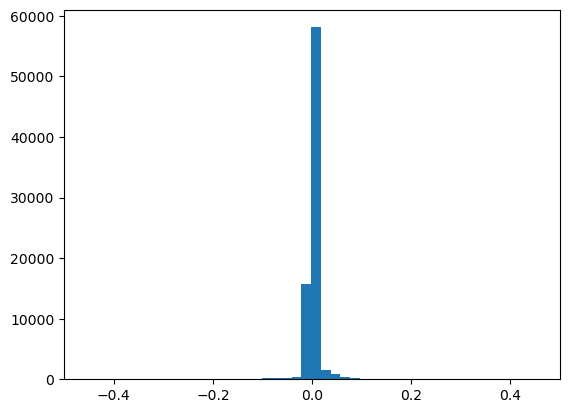

In [ ]:
# histogram of scores
import matplotlib.pyplot as plt
plt.hist(scores, bins=200)
# limit x axis to -0.5 to 0.5
plt.xlim(-0.5, 0.5)


## Plot the model prediction accuracy

To visualize the model prediction accuracy, we can plot it for each voxel on
a flattened surface of the brain. To do so, we use a mapper that is specific
to the each subject's brain. (Check previous example to see how to use the
mapper to Freesurfer average surface.)



In [ ]:
np.max(scores)

0.1952303

In [ ]:
scores.shape

(79681,)

RuntimeError: Error reading image from /var/folders/ks/z7_nk3k1019gj5y1xh7flgb40000gp/T/tmpfngtllda.png: not a PNG file (inkscape version: 1.2) (inkscape command: inkscape) (stdout: b'') (stderr: )

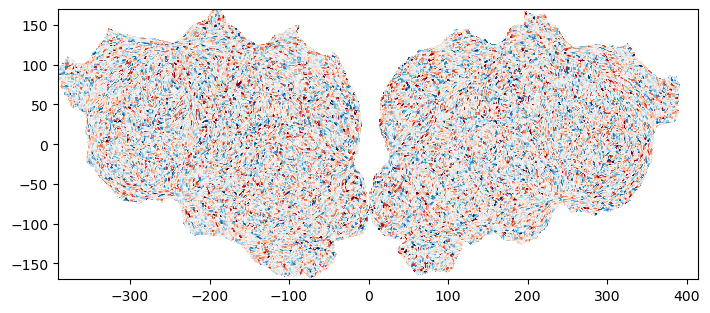

In [ ]:
# import matplotlib.pyplot as plt
# from voxelwise_tutorials.viz import plot_flatmap_from_mapper

# mapper_file = os.path.join(directory, "mappers", f"{subject}_mappers.hdf")
# ax = plot_flatmap_from_mapper(scores, mapper_file, vmin=0, vmax=0.4)
# plt.show()

import cortex 

subject = 'SPfs'
xfm = 'driving_20210126SP'
test_data = scores
test_data = np.random.randn(79681)

vol_data = cortex.Volume(test_data, subject, xfm)
cortex.quickshow(vol_data)
plt.show()

## Plot the selected hyperparameters

Since the scale of alphas is unknown, we plot the optimal alphas selected by
the solver over cross-validation. This plot is helpful to refine the alpha
grid if the range is too small or too large.

Note that some voxels might be at the maximum regularization value in the
grid search. These are voxels where the model has no predictive power, thus
the optimal regularization parameter is large to lead to a prediction equal
to zero. We do not need to extend the alpha range for these voxels.



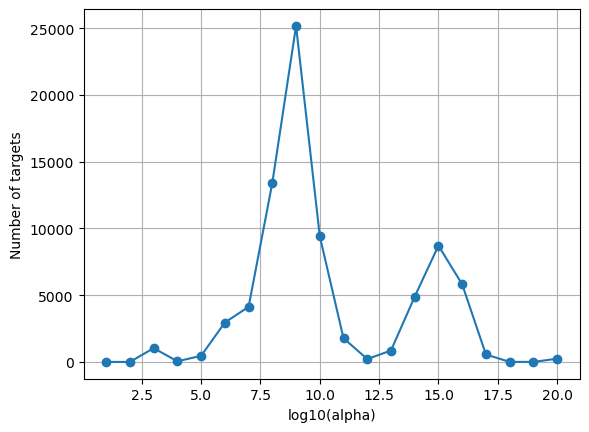

In [ ]:
from himalaya.viz import plot_alphas_diagnostic
best_alphas = backend.to_numpy(pipeline[-1].best_alphas_)
plot_alphas_diagnostic(best_alphas=best_alphas, alphas=alphas)
plt.show()

## Visualize the regression coefficients

Here, we go back to the main model on all voxels. Since our model is linear,
we can use the (primal) regression coefficients to interpret the model. The
basic intuition is that the model will use larger coefficients on features
that have more predictive power.

Since we know the meaning of each feature, we can interpret the large
regression coefficients. In the case of wordnet features, we can even build a
graph that represents the features that are linked by a semantic
relationship.



We first get the (primal) ridge regression coefficients from the fitted
model.



In [ ]:
primal_coef = pipeline[-1].get_primal_coef()
primal_coef = backend.to_numpy(primal_coef)
print("(n_delays * n_features, n_voxels) =", primal_coef.shape)


(n_delays * n_features, n_voxels) = (40, 79681)


Because the ridge model allows a different regularization per voxel, the
regression coefficients may have very different scales. In turn, these
different scales can introduce a bias in the interpretation, focusing the
attention disproportionately on voxels fitted with the lowest alpha. To
address this issue, we rescale the regression coefficient to have a norm
equal to the square-root of the $R^2$ scores. We found empirically that
this rescaling best matches results obtained with a regularization shared
accross voxels. This rescaling also removes the need to select only best
performing voxels, because voxels with low prediction accuracies are rescaled
to have a low norm.



In [ ]:

# TODO: temporary sketchy workaround
temp_norm = np.linalg.norm(primal_coef, axis=0)
temp_norm[temp_norm == 0] = 1

In [ ]:
# TODO: sketchy workaround 0 primal columns
primal_coef /= temp_norm #np.linalg.norm(primal_coef, axis=0)[None]
primal_coef *= np.sqrt(np.maximum(0, scores))[None]

Then, we aggregate the coefficients across the different delays.



In [ ]:
# split the ridge coefficients per delays
delayer = pipeline.named_steps['delayer']
primal_coef_per_delay = delayer.reshape_by_delays(primal_coef, axis=0)
print("(n_delays, n_features, n_voxels) =", primal_coef_per_delay.shape)
del primal_coef

# average over delays
average_coef = np.mean(primal_coef_per_delay, axis=0)
print("(n_features, n_voxels) =", average_coef.shape)
del primal_coef_per_delay

KeyError: 'delayer'

Even after averaging over delays, the coefficient matrix is still too large
to interpret it. Therefore, we use principal component analysis (PCA) to
reduce the dimensionality of the matrix.



In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(average_coef.T)
components = pca.components_
print("(n_components, n_features) =", components.shape)

(n_components, n_features) = (2, 8)


We can check the ratio of explained variance by each principal component.
We see that the first four components already explain a large part of the
coefficients variance.



In [ ]:
print("PCA explained variance =", pca.explained_variance_ratio_)

PCA explained variance = [0.95908052 0.03907811]


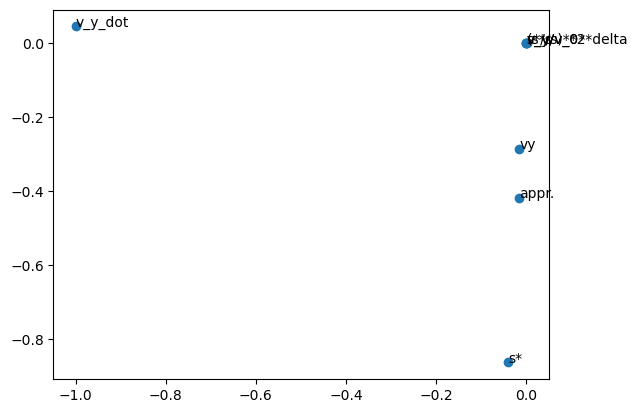

In [ ]:
plt.scatter(components[0], components[1])
labels = ["vy", "appr.", "v_y/v_0", "v_y/v_0**delta", "s*", "s*/s", "(s*/s)**2", "v_y_dot"]
for i, label in enumerate(labels):
    plt.annotate(label, (components[0, i], components[1, i]))